<h1>Plushie Defence Analysis</h1>

<p>Plushie Defence is a puzzle strategic game developed by Raccoopack Studios, Vancouver.</p>
<p>In this notebook, we are going to analyze the performance of the game testers. The interaction between the testers and the game is recorded in a dataset. The dataset contains 9420 events of 70 players between January 21 to February 7, 2020.</p>
<p>After cleaning and transforming the data, we are going to answer the following questions:</p>
<ul>
    <li>What level players drop off?</li>
    <li>How long was their play session?</li>
    <li>What level a player spends the longest time in - and how it relates to drop-off?</li>
    <li>How many attempts on each level?</li>
    <li>What's players' favorite winning team competition?</li>
</ul>
<p><img src="background.png" alt="the background image of Plushie Defence" width="100%" height="auto" /> 
</p>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from itertools import product
import json
import os
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
from pytz import timezone
import pytz
from matplotlib import pyplot as plt

In [2]:
# Load the CSV data into DataFrames
df_read_path = "../data/Events02042020.csv"
df = pd.read_csv(df_read_path)

# Display the first five rows
display(df.head())

,EventID,Data,Event,PlayerID,Time
0,0bQFrHObSJrQBOb8xqPSaw,"{""message"":{""endSource"":""WIN"",""level"":""level_2...",END_GAME,0bcdb69da2a4dfe7bb5dbb5678e47f35,Tue Jan 07 2020 20:31:02 GMT+0000 (Coordinated...
1,FMojjST-bb4C3YzQ4PeYIQ,"{""Attempt"":1,""Level"":""intro_2"",""Formation"":""Bo...",START_GAME,BBD84E3D-DD15-4CFB-BCC0-E4724F3A8689,Sun Jan 26 2020 22:12:16 GMT+0000 (Coordinated...
2,5MXt8iOFQsPfR3lCjHjhZw,"{""Level"":""level_6"",""Formation"":""Doori,Fya,Sir ...",SELECT_LEVEL,41BCB9B5-E120-4263-AFCC-0EE41ED11EDD,Sat Feb 01 2020 00:19:01 GMT+0000 (Coordinated...
3,hqfCHYnPFzIg6u5QfYTMOQ,"{""message"":{""endSource"":""LOSE"",""level"":""level_...",END_GAME,212675EB-EAD6-40F7-8170-BD15C5440FB4,Tue Jan 28 2020 06:52:38 GMT+0000 (Coordinated...
4,MB37V1ZiPxoZAo_idWEORg,"{""Level"":""level_6"",""Formation"":""Doori,Sir Atch...",EDIT_TEAM,0b5169d19638999753e3d00fc6fa7ef9,Tue Jan 07 2020 19:45:20 GMT+0000 (Coordinated...


<p>Column "Data" of the dataset contains flat JSON object. It needs to be converted. Function "load_df" which is adopted from <a href="https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook">Julian Peller</a>, will load the dataset and flatten the JSON object.</p>

In [3]:
"""
Function load_df(csv_path, nrows)
    This function reads a dataset, flattens the JSON columns in json_cols list, and 
    contructs a dataframe that contains columns written in the use_cols list. The use_cols is needed 
    to prevent column duplicates after JSON flattening.
Input:
    1. csv_path: the dataset's file name to load.
    2. nrows: number of rows to read during the data loading.
Output:
    A dataframe of the dataset.

"""
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['Data']
    df = pd.read_csv(csv_path,
                     converters = {column: json.loads for column in JSON_COLUMNS},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


# Read dataset and flatten the JSON object
df_read_path = "../data/Events02042020.csv"
df = load_df(csv_path=df_read_path, nrows=None)

Loaded Events02042020.csv. Shape: (9420, 12)


<p>We look into the dataset after the JSON object has been flattened.</p>

<h2>2. Examining the dataset</h2>

In [4]:
"""
Function convert_time_to_datetime()
    This function slices string 'Tue Jan 07 2020 20:31:02 GMT+0000 (Coordinated Universal Time)' 
    to get only 'Jan 07 2020 20:31:02 GMT+0000'. Then, convert the string to datetime type, and 
    convert the timezone from GMT to Canada/Pacific. The function also creates 'Date_Time' 
    column and drops the 'Time' column from the dataframe.
"""
def convert_time_to_datetime():
    # Slice the 'Time' string to get only 'Jan 07 2020 20:31:02 GMT+0000'
    # Convert from string type to datetime type
    # And convert the timezone from GMT to Canada/Pacific 
    df['Date_Time'] = pd.to_datetime(df['Time'].str.slice(start=4, stop=33)).dt.tz_convert('Canada/Pacific')

    #drop column 'Time'
    df.drop('Time', axis = 1, inplace=True)
    return

# Convert time to datetime
convert_time_to_datetime()

In [5]:
# Summarize the dataset
df['Date_Time'].dtype

datetime64[ns, Canada/Pacific]

In [6]:
columns = ['Event', 'Data.message.endSource','Data.Source']
values = ['END_GAME','RETRY_GAME','WINDOW_CLOSED','GAME_CLOSED']
display(df[(df['PlayerID'] == 'BBD84E3D-DD15-4CFB-BCC0-E4724F3A8689') & (df['Event'].isin(values))][columns])

,Event,Data.message.endSource,Data.Source
14,RETRY_GAME,NaN,PAUSE_MENU
553,END_GAME,LOSE,NaN
711,WINDOW_CLOSED,NaN,FORMATION_POPUP
813,END_GAME,LOSE,NaN
1146,END_GAME,WIN,NaN
1220,END_GAME,WIN,NaN
1298,END_GAME,LOSE,NaN
1357,END_GAME,WIN,NaN
1504,END_GAME,PAUSE_POPUP,NaN
1529,END_GAME,WIN,NaN


In [7]:
"""
Function gather_columns(column1, column2)
    This function bring together column1 and column2, and 
    fill the missing values with 'missing' string.
"""
def gather_columns(dataframe, column1, column2, column3):
    dataframe[column3] = dataframe[column1]
    #Fill the missing value with values of 'Data.Source'
    dataframe[column3].fillna(dataframe[column2], inplace=True)
    #Fill the missing value with 'NaN'
    dataframe[column3].fillna('missing', inplace=True)
    return dataframe

In [8]:
# Gather 'Data.message.endSource' and 'Data.Source'
df = gather_columns(df, 'Data.message.endSource', 'Data.Source', 'Source')

In [9]:
# Gather 'Data.message.team' and 'Data.Formation'
df = gather_columns(df, 'Data.message.team', 'Data.Formation', 'Team')

In [10]:
# Gather 'Data.message.level' and 'Data.Level'.
df = gather_columns(df, 'Data.message.level', 'Data.Level', 'Level')

In [11]:
# Map the level to Level_Lbl
level_lbl_map = {'intro_1' : 1, 'intro_2' : 2, 'intro_3' : 3, 'intro_4' : 4, 'level_1' : 5, 'level_2' : 6, 'level_3' : 7, 'level_4' : 8, 'level_5' : 9, 'level_6' : 10, 'level_7' : 11, 'level_8' : 12, 'level_9' : 13, 'level_10' : 14, 'level_11' : 15, 'level_12' : 16, 'level_13' : 17, 'level_14' : 18, 'level_15' : 19, 'level_16' : 20}
df['Level_lbl'] = df['Level'].map(level_lbl_map)
df['Level_lbl'].fillna(0, inplace=True)

In [12]:
# Fill the missing value in 'Data.Attempt' with 0
df['Data.Attempt'].fillna(0, inplace=True)

In [13]:
#Fill the missing value in 'Data.IsNewPlayer' with 'missing'
df['Data.IsNewPlayer'].fillna('missing', inplace=True)

In [14]:
# Summarize the dataset
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 16 columns):
EventID                   9420 non-null object
Event                     9420 non-null object
PlayerID                  9420 non-null object
Data.message.endSource    2122 non-null object
Data.message.level        2122 non-null object
Data.message.team         2122 non-null object
Data.Attempt              9420 non-null float64
Data.Level                6053 non-null object
Data.Formation            5191 non-null object
Data.Source               2638 non-null object
Data.IsNewPlayer          9420 non-null object
Date_Time                 9420 non-null datetime64[ns, Canada/Pacific]
Source                    9420 non-null object
Team                      9420 non-null object
Level                     9420 non-null object
Level_lbl                 9420 non-null float64
dtypes: datetime64[ns, Canada/Pacific](1), float64(2), object(13)
memory usage: 1.2+ MB


<h2>3. Calculate Players Performance</h2>

<p>To answer the questions stated in the begining of this notebook, we need to process the event data to understand the performance of the players. We would calculate the total time, find the number of attemps, the characters and the achievement on each level they played. As well, we will find their drop off levels.</p>

<p>In this analysis, we would like to include only the data produced by the real players, and to leave the data coming from the developers out. The developers installed the game several times in the same device, while the server recorded them as a new player with the same ID after each fresh installation. So that to filter the developers out, we apply groupby PlayerID and count method to Data.IsNewPlayer respectively.</p>
<p>Then, inside each PlayerID, the dataframe need to be sorted based on the Date_Time column.</p>

In [15]:
print('The whole number of unique players in this game:', df['PlayerID'].nunique())

The whole number of unique players in this game: 70


In [16]:
"""
Function create_realplayer(dataframe)
    This function counts the number of True in Data.IsNewPlayer column for each PlayerID, and picks 
    the players having count 1. It generate new dataframe containing event's information of these real players.
    
    Input: dataframe
    Output: list of real player
"""
def create_realplayer_list(dataframe):
    #count the frequency of being a new player, and store the frequency to column 'NewPlayer_Count'
    isTruePlayer_count = df[df['Data.IsNewPlayer'] == True].groupby('PlayerID')['PlayerID'].agg(NewPlayer_Count=pd.NamedAgg(column='Data.IsNewPlayer', aggfunc='count')).reset_index()

    #create a list of playerID having ONCE being a new player
    real_player_list = isTruePlayer_count[isTruePlayer_count['NewPlayer_Count'] == 1]['PlayerID'].reset_index(drop=True)
    
    return real_player_list

In [17]:
# Generate a list of real players
real_player_list = create_realplayer_list(df)

# Calculate the number of the real players
print('The number of real players:', real_player_list.nunique())

The number of real players: 58


In [18]:
# Filter to include only the real players and then sort it based on the Date_Time column
df = df[df['PlayerID'].isin(real_player_list)].set_index(['PlayerID', 'Date_Time']).sort_index()
df = df.reset_index()

In [19]:
display(df.head())

,PlayerID,Date_Time,EventID,Event,Data.message.endSource,Data.message.level,Data.message.team,Data.Attempt,Data.Level,Data.Formation,Data.Source,Data.IsNewPlayer,Source,Team,Level,Level_lbl
0,02FE1569-9572-4EAA-8C1B-71ABF34B52C2,2020-01-28 11:49:23-08:00,29vK5EGKlmDE5uXfixUw1g,OPEN_APP,NaN,NaN,NaN,0.0,NaN,NaN,NaN,True,missing,missing,missing,0.0
1,02FE1569-9572-4EAA-8C1B-71ABF34B52C2,2020-01-28 11:49:43-08:00,osjUQBdnF1LrAb8JhiQJNg,START_GAME,NaN,NaN,NaN,1.0,intro_1,"Bob,Marto,Cloud,Fya,",NaN,missing,missing,"Bob,Marto,Cloud,Fya,",intro_1,1.0
2,02FE1569-9572-4EAA-8C1B-71ABF34B52C2,2020-01-28 11:50:09-08:00,ayrFILalYLp7WM9YRgpujg,END_GAME,WIN,intro_1,"Bob,Marto,Cloud,Fya,",0.0,NaN,NaN,NaN,missing,WIN,"Bob,Marto,Cloud,Fya,",intro_1,1.0
3,02FE1569-9572-4EAA-8C1B-71ABF34B52C2,2020-01-28 11:50:12-08:00,dhp4hxKlxD8i_ZaTjsKqkA,RETRY_GAME,NaN,NaN,NaN,2.0,intro_1,"Bob,Marto,Cloud,Fya,",WIN_MENU,missing,WIN_MENU,"Bob,Marto,Cloud,Fya,",intro_1,1.0
4,02FE1569-9572-4EAA-8C1B-71ABF34B52C2,2020-01-28 11:50:22-08:00,JTlpBGtX4BYUfhs-vB_2qg,END_GAME,WIN,intro_1,"Bob,Marto,Cloud,Fya,",0.0,NaN,NaN,NaN,missing,WIN,"Bob,Marto,Cloud,Fya,",intro_1,1.0


<p>As the dataframe has been filtered and sorted, we can start to calculate the performance of the real players and later to store it into a different dataframe. The new dataframe contains PlayerID, label of each level, time, attempts, number of sessions, player's achievement, number of wins, number of loses on each level.</p>

In [20]:
# Levels in the game
level_list = ['intro_1', 'intro_2', 'intro_3', 'intro_4', 'level_1', 'level_2', 'level_3', 
        'level_4', 'level_5', 'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 
        'level_11', 'level_12', 'level_13', 'level_14', 'level_15', 'level_16']    

# Create 20 labels for the levels
label_list = list(range(1, 21)) 
print(label_list)

# Columns for the performance dataframe
columns = ['PlayerID', 'label', 'lvl_attempt', 'lvl_sessions', 'lvl_time', 'lvl_result', 'lvl_win', 'lvl_lose']    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [21]:
"""
Function calculate_time_interval(t1, t2)
    This function calculates interval between two times
    
    Input: t1 and t2
    Output: time difference
"""
def calculate_time_interval(t1, t2):
    return (t2 - t1).total_seconds()

"""
Function calculate_time_Session(lvl_df, length, delta_t)
    This function calculates number of session and total time spent by a player to complete one level
    
    Input: dataframe lvl_df, length of the dataframe length, time interval delta_t
    Output: total time spent and number of session
"""
def calculate_time_Session(lvl_df, length, delta_t):
    session = 1
                
    # calculate the time interval between two events
    start = lvl_df.iloc[0, 1] # column 1 is 'Data_Time'
    end = lvl_df.iloc[length-1, 1]
    interval = calculate_time_interval(start, end)
    
    # calculate total time and sessions over all events in one level
    if (interval > delta_t): # if the sessions > 1 in this level
        
        temp_interval = 0 # initialize temporary interval 
 
        i = 0 # initialize index of event
        while (i < (length-2)): # examine event by event 
            
            i_interval = calculate_time_interval(lvl_df.iloc[i, 1], lvl_df.iloc[i+1, 1])
 
            if (i_interval < delta_t):
                temp_interval += i_interval
            else:
                session += 1
            i += 1  
        lvl_time = temp_interval 

    else: # if there is only one session in this level
        lvl_time = interval
        
    lvl_sessions = session
    
    return lvl_time, lvl_sessions

In [22]:
"""
Function calculate_performance_level(df1, df2, startdate, enddate, delta_t)
    This function calculates performance of a player to complete one level.
    The performance measured includes number of attempt, number of sessions, the achievement, 
    number of wins, number of lose and time to finish one level.
    
    Input: dataframe performance df1, dataframe real player df2, start and end dates, time interval
    Output: dataframe performance df1
"""
def calculate_performance_level(df1, df2, startdate, enddate, delta_t):
    
    lvl_attempt = pd.Series()
    lvl_sessions = pd.Series()
    lvl_result = pd.Series()
    lvl_win = pd.Series()
    lvl_lose = pd.Series()
    lvl_time = pd.Series()
    
    # Loop through the dataframe:
    for idx in range(len(df1)):
        
        # create temporary dataframe
        pid = df1.loc[idx,'PlayerID']
        lvl = df1.loc[idx, 'label']
        lvl_df = df2[(df2['PlayerID'] == pid) & (df2['Level_lbl'] == lvl) & (df2['Date_Time']>startdate) & (df2['Date_Time']<enddate)].reset_index(drop=True)
    
        # calculate the time spent by pid on level lvl
        length = len(lvl_df.index)
        
        if (length > 0):
            lvl_time.at[idx], lvl_sessions.at[idx] = calculate_time_Session(lvl_df, length, delta_t)
            lvl_attempt.at[idx] = lvl_df['Data.Attempt'].max()
        else:
            lvl_sessions.at[idx]  = 0
            lvl_time.at[idx] = 0
            lvl_attempt.at[idx] = 0
        
        if (len(lvl_df[lvl_df['Source'] != 'missing']['Source']) > 0):
            lvl_result.at[idx] = lvl_df[lvl_df['Source'] != 'missing']['Source'].iloc[-1]
        else:
            lvl_result.at[idx] = 'missing'
            
        if (len(lvl_df[lvl_df['Source'] == 'WIN']['Source']) > 0):
            lvl_win.at[idx] = len(lvl_df[lvl_df['Source'] == 'WIN']['Source'])
        else: 
            lvl_win.at[idx] = 0
            
        if (len(lvl_df[lvl_df['Source'] == 'LOSE']['Source']) > 0):
            lvl_lose.at[idx] = len(lvl_df[lvl_df['Source'] == 'LOSE']['Source'])
        else:
            lvl_lose.at[idx] = 0
    
    df1['lvl_attempt'] = lvl_attempt
    df1['lvl_sessions'] = lvl_sessions
    df1['lvl_time'] = lvl_time
    df1['lvl_result'] = lvl_result
    df1['lvl_win'] = lvl_win
    df1['lvl_lose'] = lvl_lose
    
    return df1

In [23]:
"""
Function calculate_performance_total(df1, df2, startdate, enddate, delta_t)
    This function calculates performance of a player throughout the game.
    The performance measured includes game session, total time and dropoff level.
    
    Input: dataframe summary df1, dataframe real player df2, start and end dates, time interval
    Output: dataframe summary df1
"""
def calculate_performance_total(df1, df2, startdate, enddate, delta_t):
    # Initialize series for session, time and dropoff level
    game_sessions = pd.Series()
    game_time = pd.Series()
    dropoff_level = pd.Series()
    
    # Loop through the dataframe:
    for idx in range(len(df1)):
        
        # Calculate session and time
        pid = df1.loc[idx,'PlayerID']
        pid_df = df2[(df2['PlayerID'] == pid) & (df2['Date_Time']>startdate) & (df2['Date_Time']<enddate)].reset_index(drop=True)
        
        length = len(pid_df.index)
        
        if (length > 0):
            game_time.at[idx], game_sessions.at[idx] = calculate_time_Session(pid_df, length, delta_t)
        else:
            game_sessions.at[idx]  = 0
            game_time.at[idx] = 0
    
        # Find drop off level
        pid_df = df2[(df2['PlayerID'] == pid) & (df2['Level_lbl'] > 0) & (df2['Date_Time']>startdate) & (df2['Date_Time']<enddate)]['Level_lbl'].reset_index(drop=True)
        if not pid_df.empty:
            dropoff_level.at[idx] = pid_df.iloc[-1]
        else:
            dropoff_level.at[idx] = 0
            
    df1['game_sessions'] = game_sessions
    df1['game_time'] = game_time
    df1['dropoff_level'] = dropoff_level
    
    return df1

In [24]:
# Create dataframe with multiindex which is a combination of real player and label 
df_perform_lvl = pd.DataFrame(list(product(real_player_list, label_list)), columns=['PlayerID', 'label'])

In [25]:
# Create dataframe to contain performance total
df_perform_game = pd.DataFrame(real_player_list, columns=['PlayerID'])

In [26]:
# Calculate the level and overall performances
startdate = '2020-01-07 00:00:00-08:00'
enddate = '2020-04-05 00:00:00-08:00'
interval = 900
df_perform_lvl_0705 = calculate_performance_level(df_perform_lvl, df, startdate, enddate, interval)
df_perform_game_0705 = calculate_performance_total(df_perform_game, df, startdate, enddate, interval)

In [27]:
display(df_perform_lvl_0705.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 8 columns):
PlayerID        1160 non-null object
label           1160 non-null int64
lvl_attempt     1160 non-null float64
lvl_sessions    1160 non-null int64
lvl_time        1160 non-null float64
lvl_result      1160 non-null object
lvl_win         1160 non-null int64
lvl_lose        1160 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 72.6+ KB


None

In [28]:
# Convert the data type of lvl_attempt to integer
df_perform_lvl_0705['lvl_attempt'] = df_perform_lvl_0705['lvl_attempt'].astype('int64')

<h2>Answering questions</h2>

<h3>How long was their play session?</h3>

In [29]:
# Calculate average session
avg_session = '{0:.3g}'.format((df_perform_game.game_time/df_perform_game.game_sessions/60).mean())
print(f'Average session is: ', avg_session, 'seconds')

Average session is:  8.04 seconds


<h3>How many people completed each level?</h3>
<p>To know how many people completed each level, we can use information from column lvl_attempt. People who don't play any level they have 0 for lvl_attempt. Function calculate_num_players creates a dataframe to help the visualization.</p>

In [30]:
# Set the index to PlayerID and label 
df_perform_lvl_0705 = df_perform_lvl_0705.set_index(['PlayerID', 'label'])# whole

In [31]:
# Find the number of real players to use in the next step calculation
num_players = real_player_list.nunique()

In [32]:
"""
Function calculate_num_players_lvl(df)
    This function calculates the percent of players and their total effort on each level.

    Input: performance dataframe
    Output: dataframe contains %players and attempt
"""
def calculate_num_players_lvl(df):# Calculate the number of players on each level
    n_players_lvl = pd.Series([])
    pct_players_lvl = pd.Series([])
    n_attempt_lvl = pd.Series([])

    for idx in range(1, len(label_list)+1, 1):
        temp = df.loc[(slice(None), slice(idx, idx)), 'lvl_attempt']
        a = temp.sum()
        n = temp[temp>0].count()
        p = n * 100 /num_players
        n_players_lvl.at[(idx-1)] = n
        pct_players_lvl.at[(idx-1)] = p
        n_attempt_lvl.at[(idx-1)] = a
        
    # Create a dataframe
    df_nplayers_lvl = pd.DataFrame()
    # Add the Series of the number of players on each level to the dataframe
    df_nplayers_lvl['n_players_lvl'] = n_players_lvl
    # Add the Series of the percent of players on each level to the dataframe
    df_nplayers_lvl['pct_players_lvl'] = pct_players_lvl
    # Add the Series of the amount of attempts on each level to the dataframe
    df_nplayers_lvl['n_attempt_lvl'] = n_attempt_lvl
    
    return df_nplayers_lvl

In [33]:
df_nplayers_lvl_0705 = calculate_num_players_lvl(df_perform_lvl_0705)

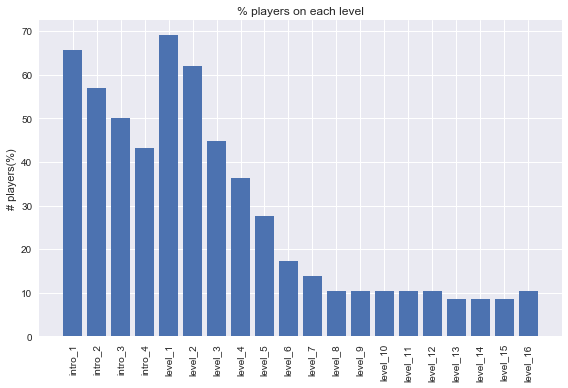

In [34]:
plt.style.use('seaborn')
x = level_list
labels = label_list

fig, axs = plt.subplots()

axs.bar(x = x, height = df_nplayers_lvl_0705['pct_players_lvl'])
axs.set_xticks(x)
axs.set_xticklabels(level_list, rotation='vertical')
axs.set_ylabel('# players(%)')
axs.set_title('% players on each level')

fig.tight_layout()
plt.show()

<p>It seems that people tends to ignore the intro levels and prefer starting playing the game from level_1.</p>

<h3>What is average attempts to complete each level?</h3>
<p>Average attempt is total attempt/total player on each level.</p>

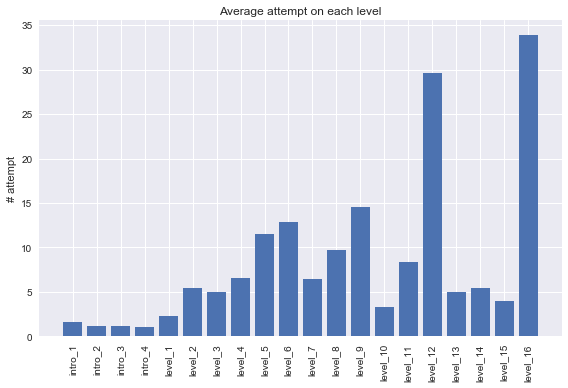

In [35]:
plt.style.use('seaborn')
x = level_list
labels = label_list

fig, axs = plt.subplots()

axs.bar(x = x, height = df_nplayers_lvl_0705['n_attempt_lvl']/df_nplayers_lvl_0705['n_players_lvl'])
axs.set_xticks(x)
axs.set_xticklabels(level_list, rotation='vertical')
axs.set_ylabel('# attempt')
axs.set_title('Average attempt on each level')

fig.tight_layout()
plt.show()

<p>The hardest five levels:</p>
<ol>
    <li>Level 16</li>
    <li>Level 12</li>
    <li>Level 9</li>
    <li>Level 6</li>
    <li>Level 5</li>
</ol>

<h3>What level players drop off?</h3>

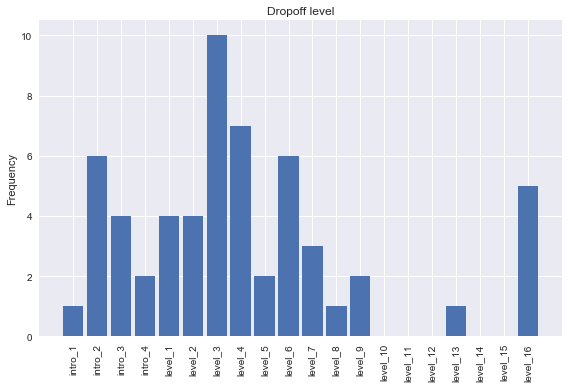

In [36]:
x = level_list
labels = label_list
fig, axs = plt.subplots()
n, bins, patches = axs.hist(df_perform_game['dropoff_level'], bins=20, rwidth=0.85)

bin_w = (max(bins) - min(bins)) / (len(bins)-1)
axs.set_xticks(np.arange(min(bins) + bin_w/2, max(bins), bin_w))
axs.set_xticklabels(level_list, rotation='vertical')
axs.set_ylabel('Frequency')
axs.set_title('Dropoff level')
fig.tight_layout()

<p>The three most drop-off levels:</p>
<ol>
    <li>Level 3</li>
    <li>Level 4</li>
    <li>Intro 2 and Level 6</li>
</ol>

<h3>What level a player spends the longest time in - and how it relates to drop-off?</h3>
<p>From the above graph we can see that most players dropped off at level_3. To answer the question whether the longest time relates to drop-off, we are going to compare the effort and performance of players dropped off at level_3 and level_16.</p>

In [37]:
# Find the playerIds who dropped of at level_3
pid_droppedoff_7 = df_perform_game[df_perform_game['dropoff_level'] == 7]['PlayerID']
print(f"Players who dropped off at level_3: \n", pid_droppedoff_7)

Players who dropped off at level_3: 
 2         101f3c83de581c5c016cf8aab44ba10f
18        4a239d36c2df709e62eedf442056d729
28    862DD7AF-32E9-47EB-B496-63ABA51C4163
30        986b13d0c05bc77ff8a0e407713c4275
31        9c7dd13e06c279e70f626c0409211ca3
48        a09b6e1fadf3b63ab5dff00688221bbe
51        daa5cff80643ccced2899f06990d6a3b
Name: PlayerID, dtype: object


In [38]:
# Get the dataframe of players who dropped of at level_3
df_droppedoff_7_time = df_perform_lvl_0705.loc[(pid_droppedoff_7, slice(None)), 'lvl_time']
df_droppedoff_7_attempt = df_perform_lvl_0705.loc[(pid_droppedoff_7, slice(None)), 'lvl_attempt']

<p>Next, we are going to plot the time and attempt of players who dropped off at level_3. The series derived in the above step is going to be unstacked to get wide dataframe, to make the plot process easier.</p>

In [39]:
# Unstack the series
df_droppedoff_7_time = df_droppedoff_7_time.unstack(level='label')
df_droppedoff_7_attempt = df_droppedoff_7_attempt.unstack(level='label')

In [40]:
# Find the playerIds who dropped of at level_16
pid_droppedoff_20 = df_perform_game[df_perform_game['dropoff_level'] == 20]['PlayerID']
print(f"Players who dropped off at level_16: \n", pid_droppedoff_20)

# Get the dataframe of players who dropped of at level_16
df_droppedoff_20_time = df_perform_lvl_0705.loc[(pid_droppedoff_20, slice(None)), 'lvl_time']
df_droppedoff_20_attempt = df_perform_lvl_0705.loc[(pid_droppedoff_20, slice(None)), 'lvl_attempt']

# Unstack the series
df_droppedoff_20_time = df_droppedoff_20_time.unstack(level='label')
df_droppedoff_20_attempt = df_droppedoff_20_attempt.unstack(level='label')


Players who dropped off at level_16: 
 7         1d5f756eeaad21046ddd9a3d605a47af
9     212675EB-EAD6-40F7-8170-BD15C5440FB4
20        5f630b5975b9e3c2925afdfc012d24de
39    C3B9ADAC-F76C-4B7F-98A0-556BBA7FE4E9
44    E8F0D964-2BF8-4AEE-89C2-8E65A56A8338
Name: PlayerID, dtype: object


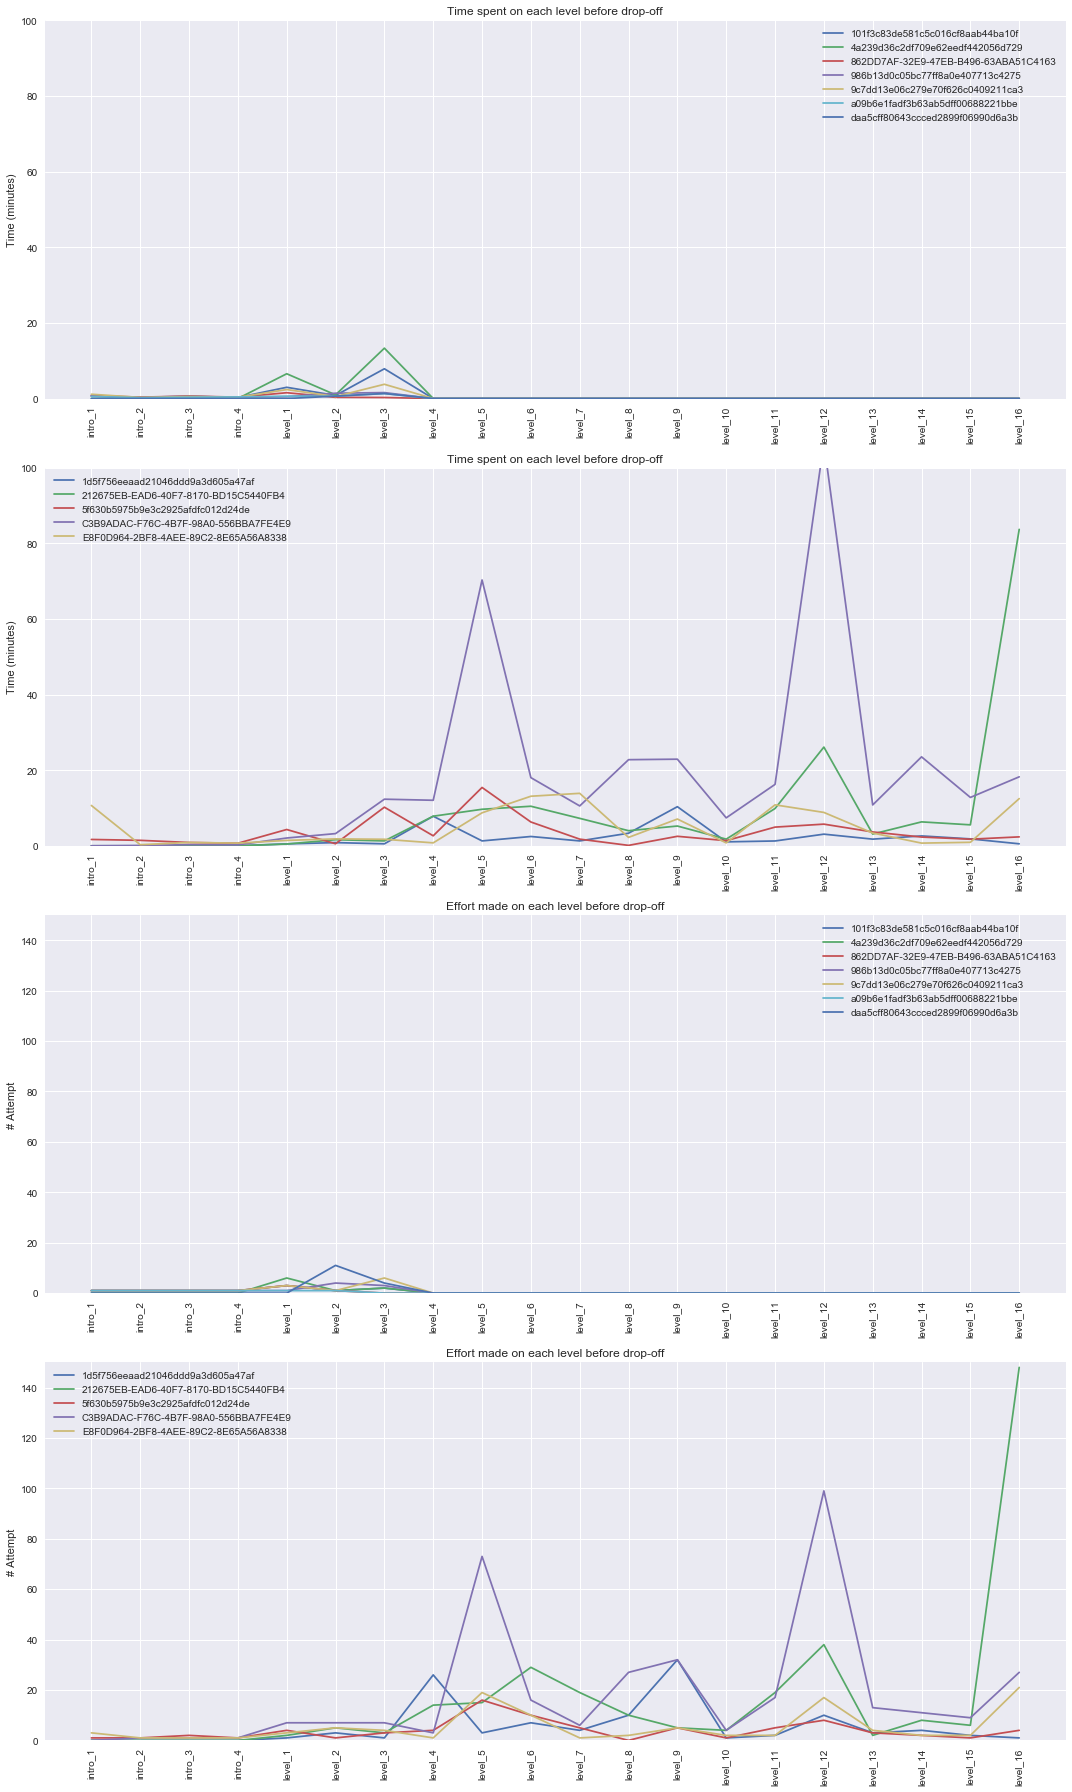

In [41]:
x = level_list
labels = label_list

fig, axs = plt.subplots(4, 1, figsize=(15, 25))
# Plot time 
for i in range(len(df_droppedoff_7_time)):
    axs[0].plot(x, df_droppedoff_7_time.iloc[i]/60, label=df_droppedoff_7_time.index[i])
axs[0].set_ylim(0, 100)
axs[0].set_xticks(x)
axs[0].set_xticklabels(level_list, rotation='vertical')
axs[0].set_ylabel('Time (minutes)')
axs[0].set_title('Time spent on each level before drop-off')

leg = axs[0].legend(loc='best', shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

# Plot time
for i in range(len(df_droppedoff_20_time)):
    axs[1].plot(x, df_droppedoff_20_time.iloc[i]/60, label=df_droppedoff_20_time.index[i])
axs[1].set_ylim(0, 100)
axs[1].set_xticks(x)
axs[1].set_xticklabels(level_list, rotation='vertical')
axs[1].set_ylabel('Time (minutes)')
axs[1].set_title('Time spent on each level before drop-off')

leg = axs[1].legend(loc='best', shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

# Plot attempt
for i in range(len(df_droppedoff_7_attempt)):
    axs[2].plot(x, df_droppedoff_7_attempt.iloc[i], label=df_droppedoff_7_attempt.index[i])
axs[2].set_ylim(0, 150)
axs[2].set_xticks(x)
axs[2].set_xticklabels(level_list, rotation='vertical')
axs[2].set_ylabel('# Attempt')
axs[2].set_title('Effort made on each level before drop-off')

leg = axs[2].legend(loc='best', shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

# Plot attempt
for i in range(len(df_droppedoff_20_attempt)):
    axs[3].plot(x, df_droppedoff_20_attempt.iloc[i], label=df_droppedoff_20_attempt.index[i])
axs[3].set_ylim(0, 150)
axs[3].set_xticks(x)
axs[3].set_xticklabels(level_list, rotation='vertical')
axs[3].set_ylabel('# Attempt')
axs[3].set_title('Effort made on each level before drop-off')

leg = axs[3].legend(loc='best', shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

fig.tight_layout()
plt.show()

In [42]:
# compare time of players who dropped off at level_3 and level_16
display(df_droppedoff_7_time)
display(df_droppedoff_20_time)
# compare attempt of players who dropped off at level_3 and level_16
display(df_droppedoff_7_attempt)
display(df_droppedoff_20_attempt)

label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PlayerID,,,,,,,,,,,,,,,,,,,,
101f3c83de581c5c016cf8aab44ba10f,40.0,18.0,37.0,17.0,178.0,49.0,472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4a239d36c2df709e62eedf442056d729,0.0,0.0,0.0,0.0,393.0,58.0,799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
862DD7AF-32E9-47EB-B496-63ABA51C4163,47.0,22.0,38.0,22.0,92.0,19.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
986b13d0c05bc77ff8a0e407713c4275,42.0,9.0,29.0,20.0,29.0,84.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9c7dd13e06c279e70f626c0409211ca3,68.0,17.0,31.0,20.0,142.0,32.0,226.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a09b6e1fadf3b63ab5dff00688221bbe,32.0,13.0,20.0,25.0,37.0,38.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
daa5cff80643ccced2899f06990d6a3b,0.0,0.0,0.0,0.0,0.0,38.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PlayerID,,,,,,,,,,,,,,,,,,,,
1d5f756eeaad21046ddd9a3d605a47af,0.0,0.0,0.0,0.0,31.0,51.0,32.0,470.0,78.0,148.0,78.0,200.0,621.0,63.0,77.0,185.0,106.0,157.0,110.0,32.0
212675EB-EAD6-40F7-8170-BD15C5440FB4,0.0,0.0,0.0,0.0,29.0,97.0,78.0,470.0,580.0,628.0,436.0,240.0,314.0,106.0,592.0,1567.0,187.0,380.0,333.0,5022.0
5f630b5975b9e3c2925afdfc012d24de,101.0,87.0,53.0,41.0,259.0,33.0,613.0,159.0,926.0,378.0,106.0,7.0,151.0,82.0,297.0,344.0,220.0,139.0,105.0,142.0
C3B9ADAC-F76C-4B7F-98A0-556BBA7FE4E9,0.0,5.0,18.0,15.0,124.0,194.0,740.0,723.0,4219.0,1082.0,633.0,1367.0,1375.0,444.0,975.0,6397.0,649.0,1412.0,768.0,1095.0
E8F0D964-2BF8-4AEE-89C2-8E65A56A8338,640.0,18.0,53.0,43.0,86.0,110.0,104.0,47.0,524.0,787.0,833.0,134.0,425.0,47.0,650.0,530.0,203.0,43.0,56.0,749.0


label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PlayerID,,,,,,,,,,,,,,,,,,,,
101f3c83de581c5c016cf8aab44ba10f,1,1,1,1,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4a239d36c2df709e62eedf442056d729,0,0,0,0,6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
862DD7AF-32E9-47EB-B496-63ABA51C4163,1,1,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
986b13d0c05bc77ff8a0e407713c4275,1,1,1,1,1,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0
9c7dd13e06c279e70f626c0409211ca3,1,1,1,1,3,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0
a09b6e1fadf3b63ab5dff00688221bbe,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
daa5cff80643ccced2899f06990d6a3b,0,0,0,0,0,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0


label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PlayerID,,,,,,,,,,,,,,,,,,,,
1d5f756eeaad21046ddd9a3d605a47af,0,0,0,0,1,3,1,26,3,7,4,10,32,1,2,10,3,4,2,1
212675EB-EAD6-40F7-8170-BD15C5440FB4,0,0,0,0,2,5,3,14,15,29,19,10,5,4,19,38,2,8,6,148
5f630b5975b9e3c2925afdfc012d24de,1,1,2,1,4,1,3,4,16,10,5,0,5,1,5,8,3,2,1,4
C3B9ADAC-F76C-4B7F-98A0-556BBA7FE4E9,0,1,1,1,7,7,7,3,73,16,6,27,32,4,17,99,13,11,9,27
E8F0D964-2BF8-4AEE-89C2-8E65A56A8338,3,1,1,1,3,5,4,1,19,10,1,2,5,2,2,17,4,2,2,21


<p>It seems that players who completed all levels spent similar effort to the ones dropped off at level_3 when they were playing at level_3. However, they were faster to overcome level_3 challenges, and they kept going to the higher levels even though they made so many attempts. People who dropped off at level 3 even hadn't started the fifth hardest level yet.</p>
<p>Players who spent longer time at four intro levels were able to complete all 20 levels faster and less effort. Passing intro levels is important.</p>